# Russian propaganda on social media

This is the code for the paper [Russian propaganda on social media during the 2022 invasion of Ukraine](https://arxiv.org/abs/2211.04154) by Dominique Geissler, Dominik Bär, Nicolas Pröllochs, and Stefan Feuerriegel.

The code has been tested on Python 3.9

This Jupyter Notebook contains the code to generate the figures in the article's main text and supplementary information.

Most of the figures are produced by intermediate data which can be generated from the raw Twitter data. Yet, these are not supplied to not violate Twitter policies.

There are a few figures that are generated by Gephi, gexf files are provided.

## Helping functions

In [83]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import geopandas as gpd
import ternary

from ternary.helpers import simplex_iterator
from os.path import join
from scipy import stats
from shapely import wkt

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [36]:
def thousands(x: float, pos):
    "format value into thousands"
    return '%1.0f' % (x * 1e-3)

In [3]:
def nplog(a, base=10):
    """Return the log value on the base of `base`.
    """
    return (np.log(a) / np.log(base))

In [4]:
def get_ccdf(df: pd.DataFrame, variable: str):
    ecdf = sm.distributions.ECDF(df[variable].values, "left")
    x = sorted(df[variable].unique())
    y = (1 - ecdf(x)) * 100
    return x, y

In [5]:
def prepare_ternary(figsize, scale):
    """Help function to ternary plot"""
    fig, ax = plt.subplots(figsize=figsize)
    tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    ax.axis('off')
    gm = 0.1 * scale
    blw = 1
    tlw = 1
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=blw)
    tax.gridlines(color='grey', multiple=gm, alpha=0.8)
    # Set Axis labels and Title
    tax.bottom_axis_label(
        r"Retweets $\rightarrow$", offset=0.2, fontsize='large')
    tax.right_axis_label(r"$\leftarrow$Replies", offset=0.2, fontsize='large')
    tax.left_axis_label(r"$\leftarrow$Tweets", offset=0.2, fontsize='large')

    # ticks
    locations = range(0, scale + 1, 4)
    ticks = [x * 10 for x in range(0, 11, 2)]
    tax.ticks(
        axis='lbr',
        ticks=ticks,
        locations=locations,
        linewidth=tlw,
        offset=0.03,
        clockwise=False)
    return tax

In [6]:
def heatmap_density(X, Y, Z, scale, boundary=True):
    """
    A function to calculate how many point located in bin (x, y, z)
    It is very suitable for hexagonal bin
    """
    X = np.around(X).astype(int)
    Y = np.around(Y).astype(int)
    Z = np.around(Z).astype(int)
    data = dict()
    for i, j, k in simplex_iterator(scale=scale, boundary=boundary):
        xb = (X == i)
        yb = (Y == j)
        zb = (Z == k)
        data[(i, j)] = (xb & yb & zb).sum()
    return data

In [7]:
def colorbar_hack(ax,
                  vmin,
                  vmax,
                  cmap,
                  log_norm=False,
                  scientific=False,
                  cbarlabel=None):
    """
    Inhanced Colorbar hack to insert colorbar on ternary plot.

    Parameters
    ----------
    vmin: float
        Minimum value to portray in colorbar
    vmax: float
        Maximum value to portray in colorbar
    cmap: Matplotlib colormap
        Matplotlib colormap to use
    log_norm: boolean,
        use LogNorm to norm the colorcmap, make sure vmin and vmax are
        sutiable for log

    """
    if log_norm is True:
        norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    print(sm)
    cb = plt.colorbar(sm, ax=ax)
    if cbarlabel is not None:
        cb.set_label(cbarlabel, fontsize=12)
    if scientific:
        cb.locator = mpl.ticker.LinearLocator(numticks=7)
        cb.formatter = mpl.ticker.ScalarFormatter()
        cb.formatter.set_powerlimits((0, 0))
        cb.update_ticks()

In [9]:
# data directory
DATA_DIR = 'data'

## Reproduction of figures

### Main Text

#### Figure 1

**Caption in the main paper:**
Temporal dynamics of Russian propaganda. The plot shows the number of pro-Russian messages during the first two weeks of the invasion. The peak on March 2, 2022, coincides with the day the United Nations General Assembly adopted Resolution ES-11/1 deploring the invasion. Inset: volume of pro-Russian messages for the entire time period of the dataset.

**Input data and instructions:**
`M1_creation_time.csv`: creation time of tweets rounded to the hour and the count of tweets posted in that hour


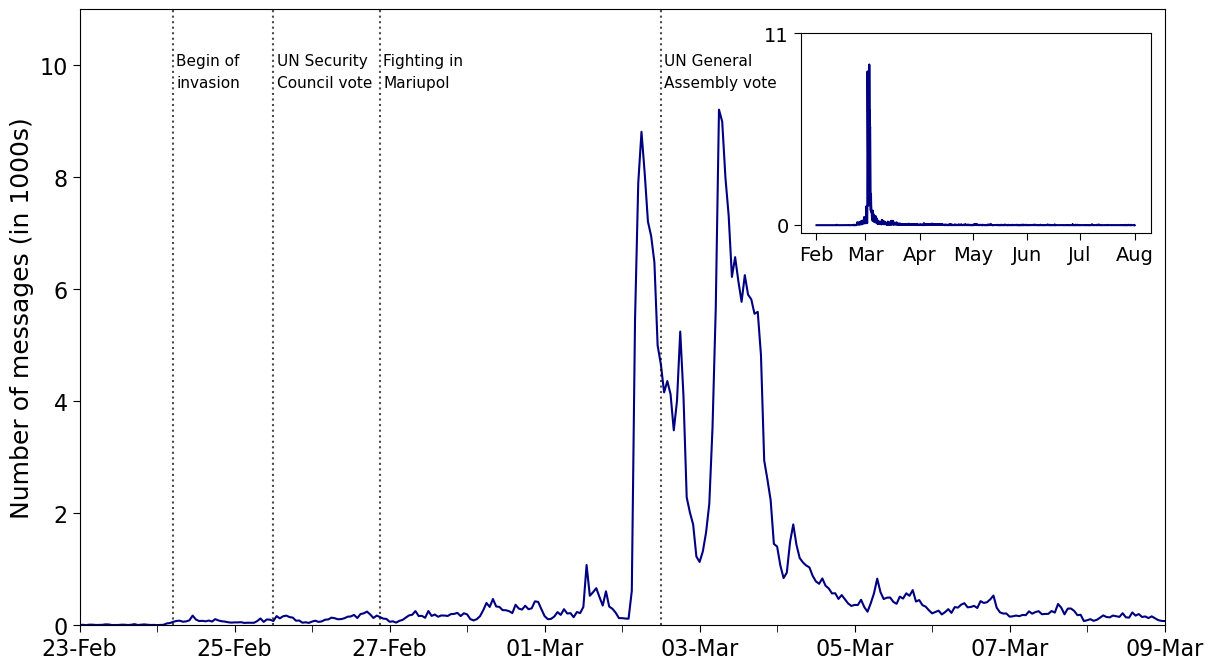

In [37]:
file = join(DATA_DIR, 'M1_creation_time.csv')
df = pd.read_csv(file, index_col=0)
df["time"] = pd.to_datetime(df["time"])

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(df['time'], df['count'], color="navy")

# annotate plot
plt.axvline(x=datetime.datetime(2022,2,24, 5), color="black", alpha=0.7, ls=":")
plt.text(x=datetime.datetime(2022,2,24, 6), y=10000, s="Begin of", fontsize=11)
plt.text(x=datetime.datetime(2022,2,24, 6), y=9600, s="invasion", fontsize=11)

plt.axvline(x=datetime.datetime(2022,3,2, 12), color="black", alpha=0.7, ls=":")
plt.text(x=datetime.datetime(2022,3, 2, 13), y=10000, s="UN General", fontsize=11)
plt.text(x=datetime.datetime(2022,3,2, 13), y=9600, s="Assembly vote", fontsize=11)

plt.axvline(x=datetime.datetime(2022,2,26, 21), color="black", alpha=0.7, ls=":")
plt.text(x=datetime.datetime(2022,2,26, 22), y=10000, s="Fighting in", fontsize=11)
plt.text(x=datetime.datetime(2022,2,26, 22), y=9600, s="Mariupol", fontsize=11)

plt.axvline(x=datetime.datetime(2022,2,25, 12), color="black", alpha=0.7, ls=":")
plt.text(x=datetime.datetime(2022,2,25, 13), y=10000, s="UN Security", fontsize=11)
plt.text(x=datetime.datetime(2022,2,25, 13), y=9600, s="Council vote", fontsize=11)

# format x axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.xlim([datetime.date(2022,2,23), datetime.date(2022,3,9)])

# format y axis
plt.ylim([0, 11000])
ax.yaxis.set_major_formatter(FuncFormatter(thousands))
ax.tick_params(axis='both', which='both', length=5,labelsize=16)
ax.grid(False)


# add axis label
plt.ylabel('Number of messages (in 1000s)', fontsize=18)
plt.xlabel('')

# this is an inset axes over the main axes
ax2 = plt.axes([.64, .6, .25, .25])
sub = sns.lineplot(data=df, x ='time', y = 'count', color="navy")
plt.ylabel('')
plt.xlabel('')
plt.xticks(list(pd.date_range("2022-02-01", "2022-08-01", freq="MS")), visible=True)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.yaxis.set_major_formatter(FuncFormatter(thousands))
plt.yticks([0, 11000])
ax2.grid(False)
ax2.tick_params(axis='both', which='both', length=5,labelsize=14)

plt.show()

#### Figure 2

**Caption in the main paper:**
Spreaders of pro-Russian messages. a, Accounts spreading pro-Russian messages were classified into humans vs. bots using Botometer [1]. b, Dates on which accounts were created. Here, the time axis starts with the inception of Twitter in 2006. c, Dates on which accounts were created. Here, the time axis starts shortly before the beginning of the 2022 Russian invasion.

##### Figure 2a:

**Input data and instructions:**
`M2a_account_type.csv`: type of account and number of accounts with that type

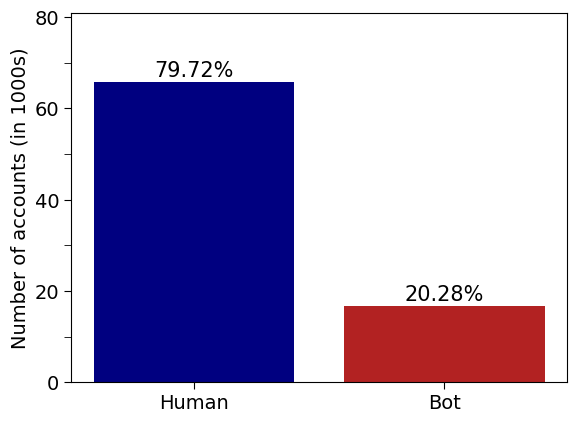

In [38]:
file = join(DATA_DIR, 'M2a_account_type.csv')
df = pd.read_csv(file, index_col=0)

fig, ax = plt.subplots()

ax.bar(df['type'], df['size'], color=["Navy", "firebrick"])

for bar in ax.patches:
    # Using Matplotlib's annotate function and passing the coordinates where the annotation shall be done
    # x-coordinate: bar.get_x() + bar.get_width() / 2
    # y-coordinate: bar.get_height()
    # free space to be left to make graph pleasing: (0, 8)
    # ha and va stand for the horizontal and vertical alignment
    ax.annotate(format(bar.get_height() / 82606 * 100, '.2f') + "%",
                (bar.get_x() + bar.get_width() / 2,
                 bar.get_height()), ha='center', va='center',
                size=15, xytext=(0, 8),
                textcoords='offset points')

# format x axis
plt.xticks(fontsize=14)

# format y axis
ax.yaxis.set_major_formatter(FuncFormatter(thousands))
ax.yaxis.set_minor_locator(ticker.AutoLocator())
plt.yticks(range(0, 80001, 20000), fontsize=14)
plt.ylim([0, 81000])

ax.tick_params(axis='both', which='both', length=5, labelsize=14)

# label axis
plt.ylabel('Number of accounts (in 1000s)', fontsize=14)
plt.xlabel('')

plt.show()

##### Figure 2b:

**Input data and instructions:**
`M2b_human_creation_time.csv`: number of users created in the same week
`M2b_bot_creation_time.csv`: number of bots created in the same week

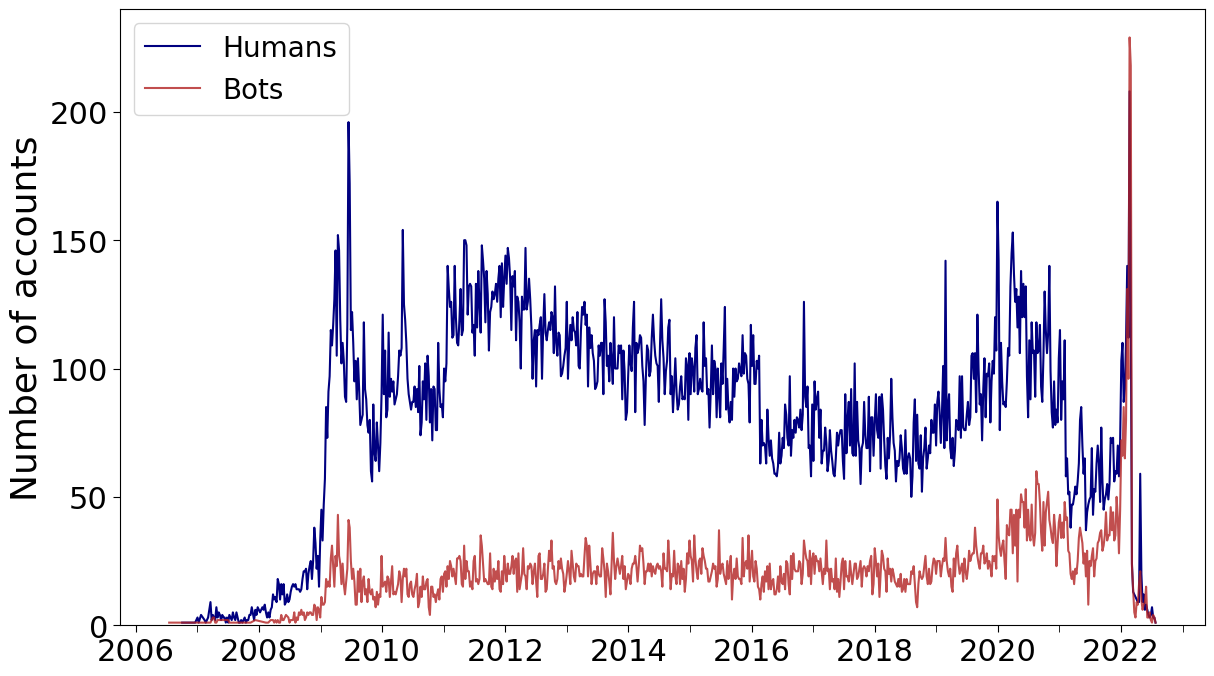

In [40]:
file1 = join(DATA_DIR, 'M2b_human_creation_time.csv')
df1 = pd.read_csv(file1, index_col=0)
df1["time"] = pd.to_datetime(df1["time"])

file2 = join(DATA_DIR, 'M2b_bot_creation_time.csv')
df2 = pd.read_csv(file2, index_col=0)
df2["time"] = pd.to_datetime(df2["time"])

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(df1['time'], df1['count'], color="navy")
ax.plot(df2['time'], df2['count'], color="firebrick", alpha=0.8)

plt.ylim([0, 240])
ax.xaxis.set_minor_locator(mdates.YearLocator())
ax.tick_params(axis='both', which='both', length=5,labelsize=22)

# add axis label
plt.ylabel('Number of accounts', fontsize=26)
plt.xlabel('')

# add legend
ax.legend(labels=["Humans", "Bots"], fontsize=20, loc=2)

plt.show()

##### Figure 2c:

**Input data and instructions:**
`M2c_human_creation_time.csv`: number of users created on the same day
`M2c_bot_creation_time.csv`: number of bots created on the same day

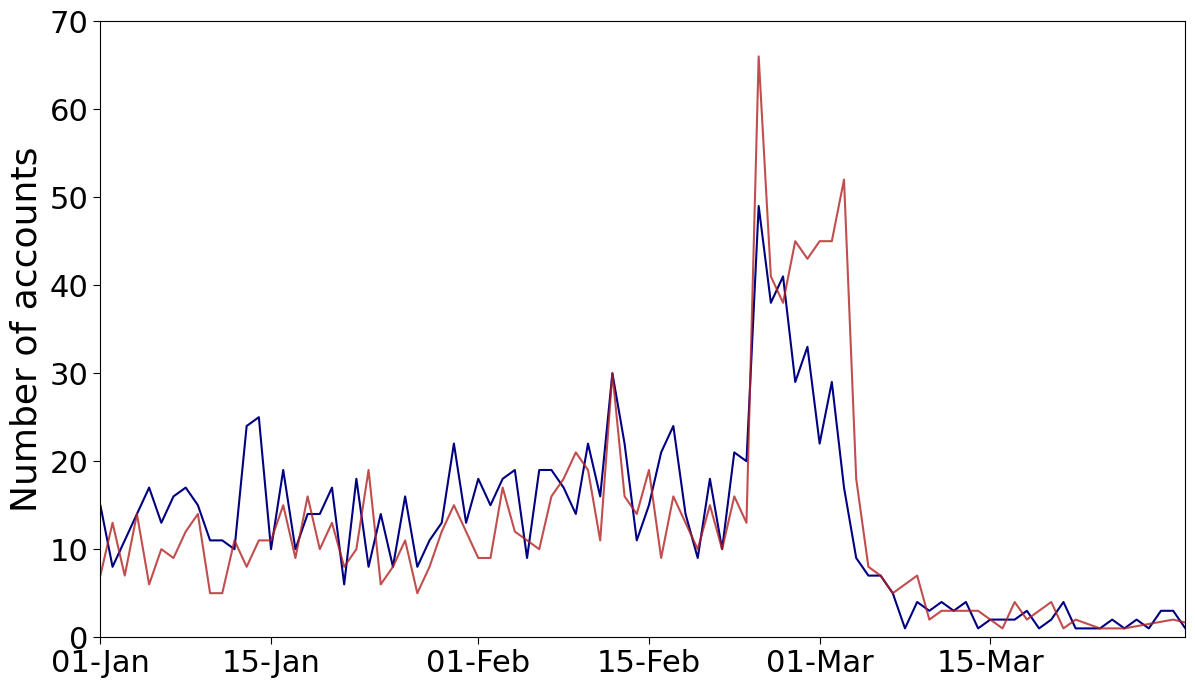

In [41]:
file1 = join(DATA_DIR, 'M2c_human_creation_time.csv')
df1 = pd.read_csv(file1, index_col=0)
df1["time"] = pd.to_datetime(df1["time"])

file2 = join(DATA_DIR, 'M2c_bot_creation_time.csv')
df2 = pd.read_csv(file2, index_col=0)
df2["time"] = pd.to_datetime(df2["time"])

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(df1['time'], df1['count'], color="navy")
ax.plot(df2['time'], df2['count'], color="firebrick", alpha=0.8)

# format x axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xlim([datetime.date(2022,1,1), datetime.date(2022,3,31)])

# format y axis
plt.ylim([0, 70])
ax.tick_params(axis='both', which='both', length=5,labelsize=22)

# add axis label
plt.ylabel('Number of accounts', fontsize=26)
plt.xlabel('')

plt.show()

#### Figure 3

**Caption in the main paper:**
Online virality of pro-Russian vs. pro-Ukrainian support. Here, we compare complementary cumulative distribution functions (CCDFs) for: a, the number of followers; b, the number of likes; c the number of replies; and d, the number of retweets. The former was computed at the user level, while the latter three were computed at the tweet level. Statistical comparisons are based on Kolmogorov-Smirnov (KS) tests [2]. All distributions span several orders of magnitude, implying that there was a substantial share of pro-Russian messages that went viral.

**Input data and instructions:**
`M3_russian_tweets.csv`: pro-Russian tweets, author ids and public_metrics
`M3_ukrainian_tweets.csv`: pro-Ukrainian tweets, author ids and public metrics

In [42]:
file1 = join(DATA_DIR, 'M3_russian_tweets.csv')
df1 = pd.read_csv(file1, index_col=0)

file2 = join(DATA_DIR, 'M3_ukrainian_tweets.csv')
df2 = pd.read_csv(file2, index_col=0)

In [43]:
y_indixes = [0.001, 0.01, 0.1, 1, 10, 100]

def ccdf_plot(
        variable: str,
        xlabel: str,
        df_blue: pd.DataFrame,
        df_yellow: pd.DataFrame,
        legend=False
        ):
    # configurations
    tick_size = 18
    text_size = 20

    # compute KS-test
    ks = stats.kstest(df_blue[variable].values, df_yellow[variable].values)
    print(f"The p-value of the KS-test is: {ks.pvalue}.")
    mean_blue = df_blue[variable].mean()
    mean_yellow = df_yellow[variable].mean()
    print(f"The mean for Russia is: {mean_blue} and for Ukraine is {mean_yellow}.")

    # plot the ccdfs
    fig, axs = plt.subplots(figsize=(8,8))

    # compute ccdfs
    x, y = get_ccdf(df_blue, variable)
    plt.step(x, y, color="Navy",linewidth=3.0)
    x, y = get_ccdf(df_yellow, variable)
    plt.step(x, y, color="#ffd700",linewidth=3.0)

    # format x axis
    axs.set_xscale('log')
    axs.minorticks_on()
    axs.tick_params(axis='x', which='both', direction='out', bottom=True, size=7)
    plt.xticks(fontsize=tick_size)
    plt.xlim([1,1000000000])

    # format y axis
    plt.ylim([0.001, 101])
    axs.set_yscale("log")
    axs.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    axs.tick_params(axis='y', which='major', direction='out', left=True, size=7)
    axs.tick_params(axis='y', which='minor', direction='out', left=True, size=4)
    plt.yticks(y_indixes, fontsize=tick_size)

    # label axes
    axs.set_ylabel("CCDF (%)", fontsize=text_size)
    axs.set_xlabel(xlabel, fontsize=text_size)

    if legend:
        axs.legend(labels=["Pro-Russia", "Pro-Ukraine"], loc='lower left', fontsize=text_size)

    axs.text(10000, 60, "KS-test: D=" + str(np.round(ks.statistic, 3)) + ", p<" + str(0.001), fontsize=tick_size)
    plt.show()

##### Figure 3a

The p-value of the KS-test is: 0.0.
The mean for Russia is: 1689.9381220152727 and for Ukraine is 534122.1424899198.


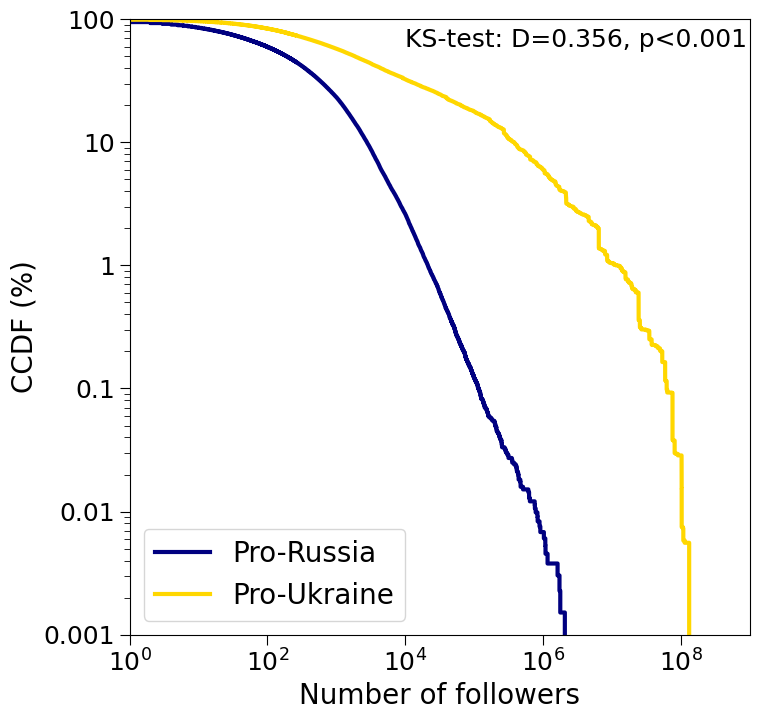

In [44]:
df_followers1 = df1.groupby(["author_id"])[["followers_count"]].agg("first").reset_index()
df_followers2 = df2.groupby(["author_id"])[["followers_count"]].agg("first").reset_index()

ccdf_plot(
    "followers_count",
    "Number of followers",
    df_followers1,
    df_followers2,
    legend=True
)

##### Figure 3b-d

The p-value of the KS-test is: 4.04872886597593e-30.
The mean for Russia is: 4.859504786013765 and for Ukraine is 6.556466714079275.


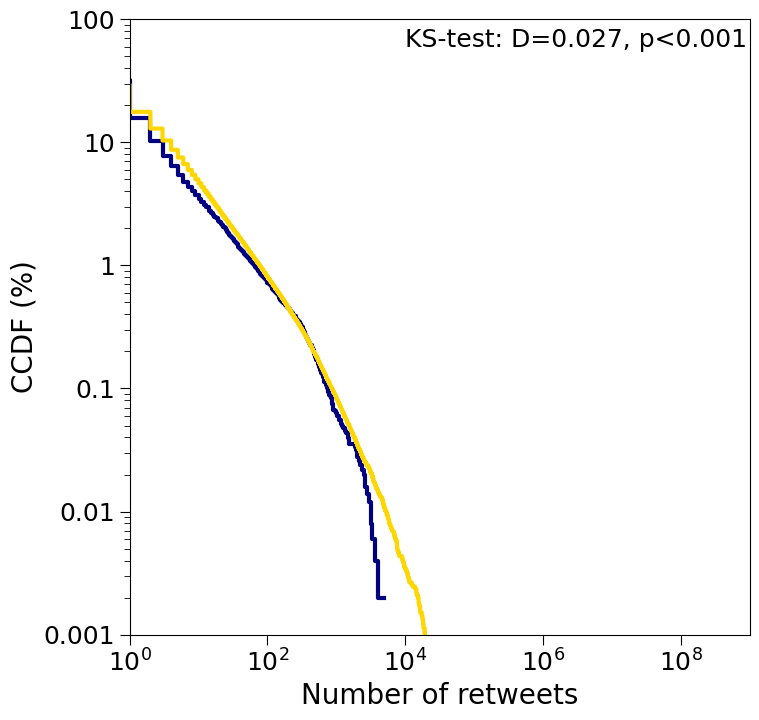

The p-value of the KS-test is: 0.0.
The mean for Russia is: 18.680523692745826 and for Ukraine is 28.352946517064755.


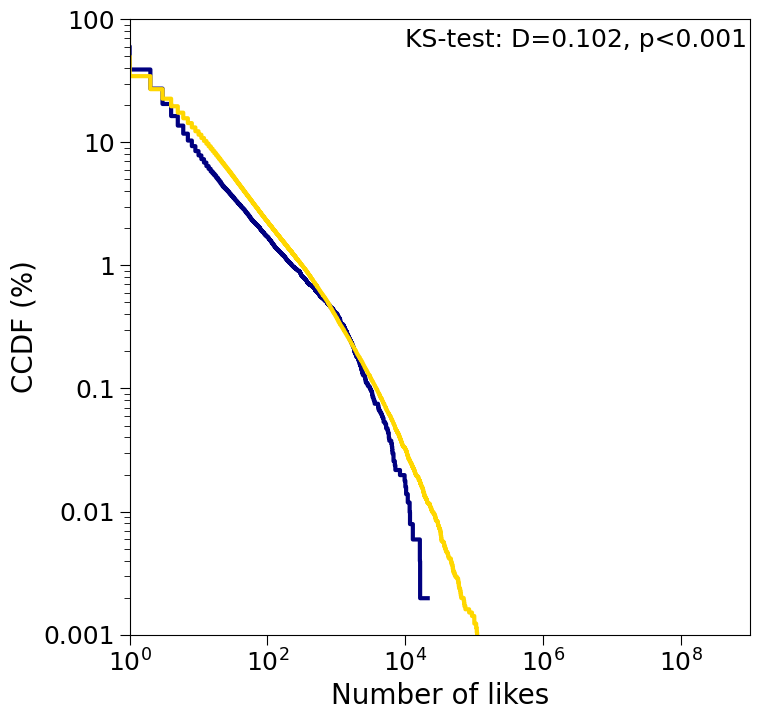

The p-value of the KS-test is: 0.0.
The mean for Russia is: 1.6688355351633573 and for Ukraine is 1.2200865532294796.


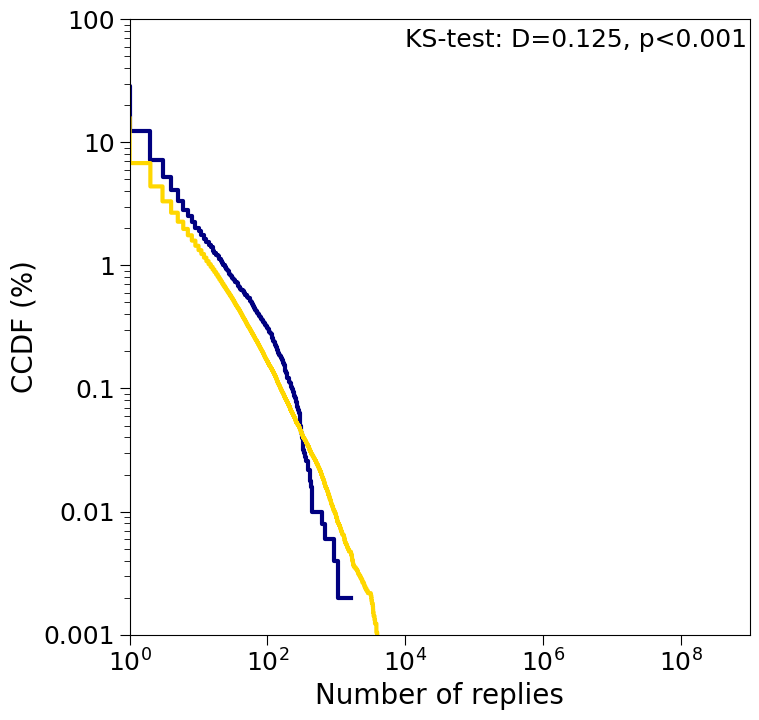

In [45]:
df_source_tweets1 = df1[df1["type"] == "original"]
df_source_tweets2 = df2[df2["tweet_type"] == "original"]

# plot retweet count
ccdf_plot(
    "retweet_count",
    "Number of retweets",
    df_source_tweets1,
    df_source_tweets2
)

# plot like count
ccdf_plot(
    "like_count",
    "Number of likes",
    df_source_tweets1,
    df_source_tweets2
)

# plot retweet count
ccdf_plot(
    "reply_count",
    "Number of replies",
    df_source_tweets1,
    df_source_tweets2
)

#### Figure 4

**Caption in the main paper:**
Cross-country differences in the spread of Russian propaganda. Here, we inferred the geographic location of accounts (see Methods). a, Number of users per country (log scale). b, Relative frequency of bots per country (in %).

**Input data and instructions:**
`M4_locations.csv`: countries, their polygon values, and the number of users and mean bot percentage per country

In [65]:
file = join(DATA_DIR, 'M4_locations.csv')
df = pd.read_csv(file)
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry="geometry",crs=4326)

Text(1390.6530683051215, 0.5, 'Number of accounts')

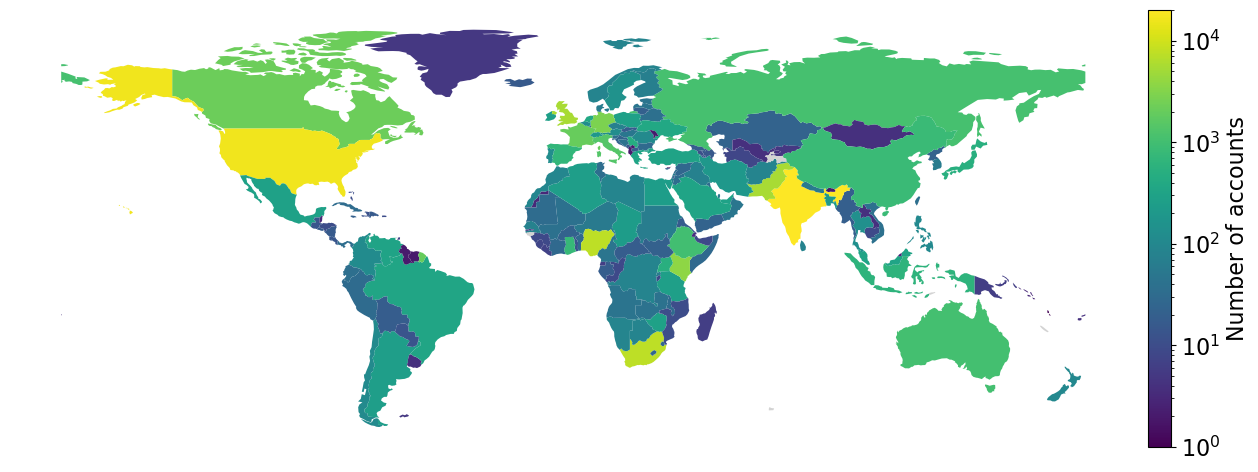

In [67]:
%matplotlib inline

# Figure 4a
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# create worldmap and legend space
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

# plot worldmap and legend
a = df.plot(
    column="nr_of_users",
    cmap="viridis",
    legend=True,
    norm=colors.LogNorm(
        vmin=df.nr_of_users.min(),
        vmax=df.nr_of_users.max()
    ),
    missing_kwds= {"color": "lightgrey", "label": "Missing values"},
    ax=ax,
    cax=cax
)

# format worldmap
ax.axis("off")

# format legend
cax.tick_params(labelsize=16)
cax.set_ylabel('Number of accounts', rotation=90, fontsize=16)

Text(1383.0277777777776, 0.5, 'Relative frequency of bots (in %)')

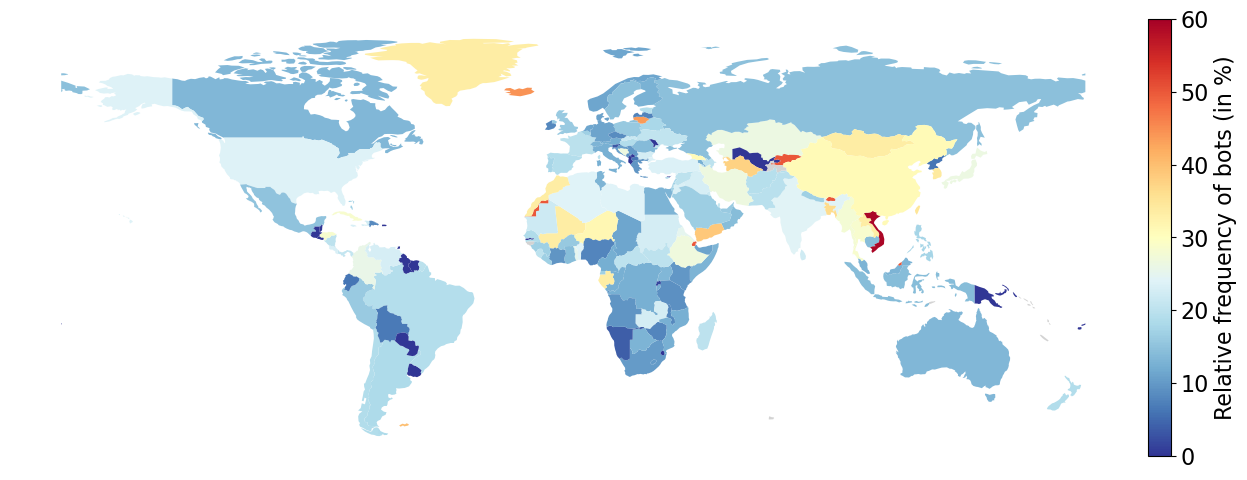

In [69]:
# Figure 4b
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# create worldmap and legend space
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

# plot worldmap and legend
a = df.plot(
    column="bot_mean",
    cmap="RdYlBu_r",
    legend=True,
    vmax=60,
    missing_kwds= {"color": "lightgrey", "label": "Missing values"},
    ax=ax,
    cax=cax
)

# format worldmap
ax.axis("off")

# format legend
cax.tick_params(labelsize=16)
cax.set_ylabel('Relative frequency of bots (in %)', rotation=90, fontsize=16)

#### Figure 5

**Caption in the main paper:**
Retweeting network. a, Spreading patterns between humans vs. bots (blue = human, red = bot). The node size represents the number of humans vs. bots. The edges represent the direction and relative frequency of retweets. b, Retweet network with accounts from India colored in purple. c, Retweet network with accounts from the U.S. colored in blue. d, Retweet network with accounts from South Africa colored in green. The node size represents the weighted degree of an individual account (see Methods). The retweet networks were visualized using Gephi [3].

**Input data and instructions:**
Please check the gephi files in the networks directory

#### Figure 6

**Caption in the main paper:**
Online behaviour of different account types. a, Percentage of source tweets, retweets, and replies of humans. b, Percentage of source tweets, retweets, and replies of bots. We map each account along the three axes representing the different types of messages (source tweets, retweets, and replies) that accounts post. The color represents the number of users with the same online behavior pattern (log scale).

##### Figure 6a
**Input data and instructions:**
`M6_online_behavior_humans.csv`: authors and their number of source tweets, retweets, quotes, replies and overall messages.

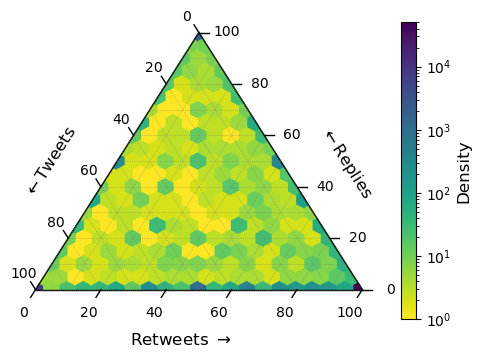

In [73]:
file = join(DATA_DIR, 'M6_online_behavior_humans.csv')
df = pd.read_csv(file, index_col=0)

scale = 20

X = ((df.nretweets + df.nquotes) / df.ntotal * scale).values
Y = (df.nreplies / df.ntotal * scale).values
Z = (df.norigins / df.ntotal * scale).values

data = heatmap_density(X, Y, Z, scale)
data = pd.Series(data)
vmin = data.min()
vmax = data.max()
data = data.apply(lambda x: np.log10(x + 1))
if vmin <= 0:
    vmin = 1

data = data.to_dict()

cmap = plt.cm.get_cmap('viridis_r')

tax = prepare_ternary(figsize=(5, 3.5), scale=20)
tax.heatmap(
    data,
    cmap=cmap,
    style='hexagonal',
    colorbar=False,
)

colorbar_hack(
    ax=tax.ax,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    log_norm=True,
    cbarlabel='Density')

plt.tight_layout()
plt.show()

##### Figure 6b

**Input data and instructions:**
`M6_online_behavior_bots.csv`: authors and their number of source tweets, retweets, quotes, replies and overall messages.

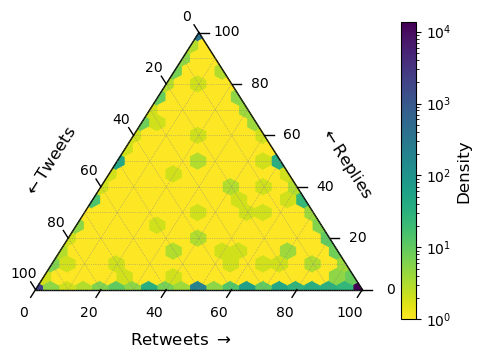

In [80]:
file = join(DATA_DIR, 'M6_online_behavior_bots.csv')
df = pd.read_csv(file, index_col=0)

scale = 20

X = ((df.nretweets + df.nquotes) / df.ntotal * scale).values
Y = (df.nreplies / df.ntotal * scale).values
Z = (df.norigins / df.ntotal * scale).values

data = heatmap_density(X, Y, Z, scale)
data = pd.Series(data)
vmin = data.min()
vmax = data.max()
data = data.apply(lambda x: np.log10(x + 1))
if vmin <= 0:
    vmin = 1

data = data.to_dict()

cmap = plt.cm.get_cmap('viridis_r')

tax = prepare_ternary(figsize=(5, 3.5), scale=20)
tax.heatmap(
    data,
    cmap=cmap,
    style='hexagonal',
    colorbar=False,
)

colorbar_hack(
    ax=tax.ax,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    log_norm=True,
    cbarlabel='Density')

plt.tight_layout()
plt.show()

#### Figure 7

**Caption in the main paper:**
Impact of humans and bots. a, Distribution of bot scores for source tweets and retweets. The two groups had significantly different scores (Mann-Whitney U test: U = 2 · 109; p < 0.001), implying that retweeters were more likely to be bots. b, Joint distribution of bot scores of authors of source tweet-retweet pairs (heatmap). The top subplot shows the distribution of bot scores for retweeters. The left subplot shows the distribution of bot scores for accounts that were retweeted by accounts classified as humans (using a threshold of 0.5). We find that most source tweets were posted by humans. They were also active retweeters, but so were bots. Different from the spread of low-credibility content [4], we find that a significant proportion of retweeters were bots and that they tended to retweet humans rather than other bots.

##### Figure 7a
**Input data and instructions:**
`M7a_retweeter_bot_score.csv`: id and bot score of retweeters
`M7a_tweeter_bot_score.csv`: id and bot score of source tweeters

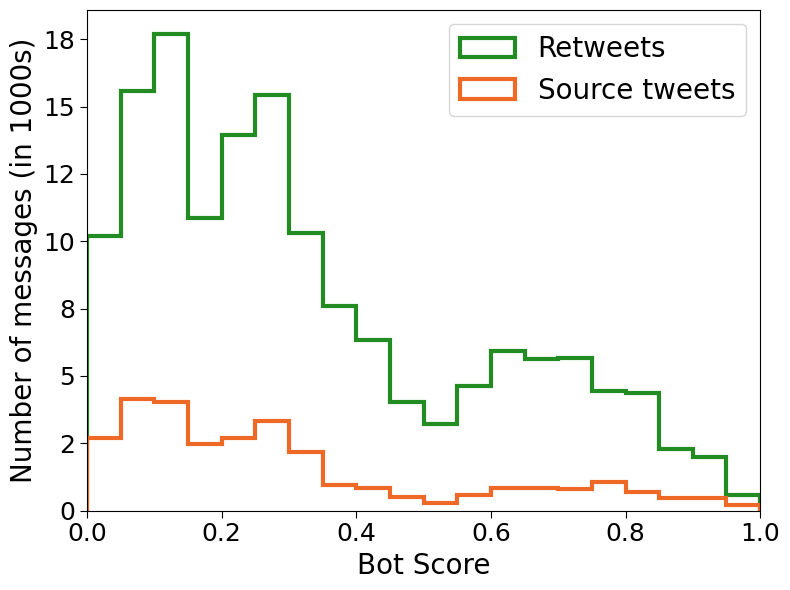

In [84]:
nbins = 20
fontsize= 20
tick_size = 18

file1 = join(DATA_DIR, 'M7a_retweeter_bot_score.csv')
df1 = pd.read_csv(file1, index_col=0)

file2 = join(DATA_DIR, 'M7a_tweeter_bot_score.csv')
df2 = pd.read_csv(file2, index_col=0)

a1 = df1["bot_score"].values
a2 = df2["bot_score"].values

fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(0, 1, nbins + 1)
ax.set_xlim([0, 1])

ax.hist(
    a1,
    bins,
    alpha=1,
    label='Retweets',
    histtype='step',
    color="forestgreen",
    linewidth=3.0)
ax.hist(
    a2,
    bins,
    alpha=1,
    label='Source tweets',
    histtype='step',
    color="#ED6925",
    linewidth=3.0)

# format axes
ax.tick_params(axis='both', which='both', direction='out', size=5)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.yaxis.set_major_formatter(FuncFormatter(thousands))

# legend and labels
plt.legend(loc='upper right', fontsize=fontsize)
ax.set_xlabel('Bot Score', fontsize=fontsize)
ax.set_ylabel('Number of messages (in 1000s)', fontsize=fontsize)

plt.tight_layout()
plt.show()

##### Figure 7b
**Input data and instructions:**
`M7b_tweet_retweet_pairs.csv`: tweet id and bot score of retweeter and source tweeter

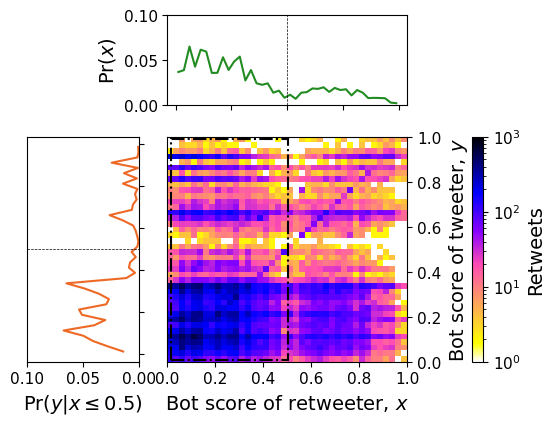

In [85]:
nbins = 40
figsize=(6, 4.5)
fontsize=14
ticksize=5
labelsize=11

file = join(DATA_DIR, 'M7b_tweet_retweet_pairs.csv')
df = pd.read_csv(file, index_col=0)

x = df["bot_score"].values
y = df["bot_score_ref"].values
H, xedges, yedges = np.histogram2d(x, y, bins=np.linspace(0.0, 1.0, nbins + 1))

# X1, Y1, horizontal curve
df_H = pd.DataFrame(H)
X1 = xedges[:-1] + np.true_divide(xedges[1:] - xedges[:-1], 2)
Y1 = df_H.sum(axis=1) / df_H.sum(axis=1).sum()
# X2, Y2, vertical curve
df2 = df_H.iloc[:int(0.4 * nbins)]
X21 = df2.sum(axis=0) / df_H.sum(axis=0).sum()
df2 = df_H.iloc[:int(0.5 * nbins)]
X22 = df2.sum(axis=0) / df_H.sum(axis=0).sum()
df2 = df_H.iloc[:int(0.6 * nbins)]
X23 = df2.sum(axis=0) / df_H.sum(axis=0).sum()
Y2 = X1
# X3, Y3, heatmap
X3, Y3 = np.meshgrid(xedges, yedges)

plt.figure(figsize=figsize)

# Display -> Figure
gs = gridspec.GridSpec(
    2,
    4,
    wspace=0.3,
    hspace=0.2,
    width_ratios=[2.8, 6, 0.2, 0.5],
    height_ratios=[0.8, 2])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[1, 3])

# horizontal curve
ax1.plot(X1, Y1, color="forestgreen")
# hide grid lines
ax1.grid(False)
# disable xticklabels of ax1
ax1.set_xticklabels([])
ax1.yaxis.tick_left()
ax1.tick_params(axis='y', which='major',labelsize=labelsize)
# set tick on bottom xaxis of ax1
ax1.xaxis.tick_bottom()
# add vertical dashed line on ax1
ax1.axvline(0.5, color='k', linestyle='--', lw=0.5)
# add xlabel
ax1.set_ylabel('$\Pr(x)$', fontsize=fontsize)
ax1.set_ylim((0, 0.1))


# vertical curve
ax2.plot(X22, Y2, color='#ED6925', label='$0.5$')
# hide grid lines
ax2.grid(False)
# disable xticklabels of ax2
ax2.set_yticklabels([])
# set tick on right yaxis of ax2
ax2.yaxis.tick_right()
ax2.xaxis.tick_bottom()
ax2.tick_params(axis='x', which='major',labelsize=labelsize)
# add horizontal dashed line on ax2
ax2.axhline(0.5, color='k', linestyle='--', lw=0.5)
# set inverse xlim of ax2, making xaxis increasing on inverse direction
ax2.set_xlim((0.1, 0))
# add ylabel
ax2.set_xlabel('$\Pr(y|x\leq 0.5)$', fontsize=fontsize)


# heatmap
im = ax3.pcolormesh(
    X3,
    Y3,
    H.T,
    norm=mpl.colors.LogNorm(vmin=H.min() + 1, vmax=1000),
    cmap='gnuplot2_r')

# color bar
cb = plt.colorbar(im, ax=ax4, orientation='vertical', fraction=1)
cb.ax.tick_params(labelsize=labelsize)
cb.set_label('Retweets', fontsize=fontsize)

# set xlabel of ax3
ax3.set_xlabel('Bot score of retweeter, $x$', fontsize=fontsize)
# set tick on bottom xaxis of ax3
ax3.xaxis.tick_bottom()
# set ylabel of ax3
ax3.yaxis.tick_right()
ax3.tick_params(axis='both', which='major',labelsize=labelsize)
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Bot score of tweeter, $y$', fontsize=fontsize)
# disable axis
ax4.axis('off')
# add rectangel for ax3
rect = mpl.patches.Rectangle(
    (0.015, 0.008),
    0.49,
    0.98,
    alpha=1,
    ec='black',
    facecolor=None,
    fill=False,
    ls='-.',
    lw=1.5)
ax3.add_patch(rect)
plt.show()

#### Figure 8

**Caption in the main paper:**
Bot strategies. a, Distribution of bot scores of accounts that retweeted human-made source tweets grouped by different time lags between source tweet and the corresponding retweet. b, Distribution of bot scores of accounts that retweeted bot-made source tweets grouped by different time lags between the source tweet and the corresponding retweet. Hence, bots (but not humans) tended to retweet bots to promote the early diffusion of propaganda. c, Here, we plot the average number of followers of mentioned accounts to analyze whether bots specifically targeted influential user. The mentioning accounts are grouped by their bot score percentile. Error bars indicate the standard errors. Inset: violin plot showing the distribution of follower counts for the mentioned users accounts in each bot score group. In violin plots, the width of a contour represents the probability of the corresponding value, and the median is marked by a colored line.

##### Figure 8a
**Input data and instructions:**
`M8a_retweeters_of_humans.csv`: tweet id, bot score of retweeter and time lag of retweet



Maximum seconds is: %s 3600.0
xbins are %s [   1  181  361  541  721  901 1081 1261 1441 1621 1801 1981 2161 2341
 2521 2701 2881 3061 3241 3421 3601]


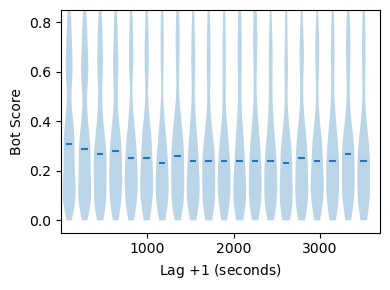

In [88]:
base = 10

file = join(DATA_DIR, 'M8a_retweeters_of_humans.csv')
df = pd.read_csv(file, index_col=0)

df.sort_values('seconds', inplace=True, ascending=True)
X = df.seconds.values + 1
print('Maximum seconds is: %s', X.max())
if len(df.loc[df.seconds == 1]) > 0:
    nxbins = int(np.ceil(nplog(X.max(), base=base))) + 1
    xbins = np.ones(nxbins + 1)
    xbins[1:] = 1 + base**np.arange(0, nxbins)
else:
    xbins = np.arange(1, 3602, 180)
    nxbins = len(xbins) -1

print('xbins are %s', xbins)
data = []

for i in range(nxbins):
    dfi = df.loc[(X >= xbins[i]) & (X < xbins[i + 1])]
    data.append(dfi.bot_score.values)

f, ax = plt.subplots(figsize=(4, 3))
positions = xbins[:-1] + np.true_divide(xbins[1:] - xbins[:-1], 2)

ax.violinplot(
    data,
    positions=positions,
    vert=True,
    widths=150,
    showmeans=False,
    showextrema=False,
    showmedians=True,
    points=100,
)
ax.set_xlabel('Lag $+1$ (seconds)')
ax.set_ylabel('Bot Score')
ax.set_ylim([-0.05, 0.85])
ax.set_xlim([1, 3700])
plt.tight_layout()
plt.show()

##### Figure 8b
**Input data and instructions:**
`M8b_retweeters_of_bots.csv`: tweet id, bot score of retweeter and time lag of retweet

Maximum seconds is: %s 3600.0
xbins are %s [   1  181  361  541  721  901 1081 1261 1441 1621 1801 1981 2161 2341
 2521 2701 2881 3061 3241 3421 3601]


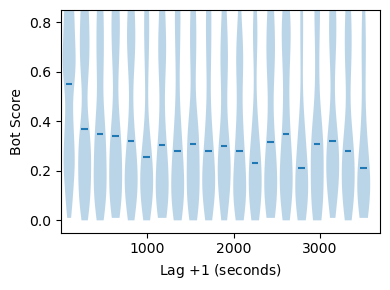

In [89]:
file = join(DATA_DIR, 'M8b_retweeters_of_bots.csv')
df = pd.read_csv(file, index_col=0)

base = 10

df.sort_values('seconds', inplace=True, ascending=True)
X = df.seconds.values + 1
print('Maximum seconds is: %s', X.max())
if len(df.loc[df.seconds == 1]) > 0:
    nxbins = int(np.ceil(nplog(X.max(), base=base))) + 1
    xbins = np.ones(nxbins + 1)
    xbins[1:] = 1 + base**np.arange(0, nxbins)
else:
    xbins = np.arange(1, 3602, 180)
    nxbins = len(xbins) -1

print('xbins are %s', xbins)
data = []

for i in range(nxbins):
    dfi = df.loc[(X >= xbins[i]) & (X < xbins[i + 1])]
    data.append(dfi.bot_score.values)

f, ax = plt.subplots(figsize=(4, 3))
positions = xbins[:-1] + np.true_divide(xbins[1:] - xbins[:-1], 2)

ax.violinplot(
    data,
    positions=positions,
    vert=True,
    widths=150,
    showmeans=False,
    showextrema=False,
    showmedians=True,
    points=100,
)
ax.set_xlabel('Lag $+1$ (seconds)')
ax.set_ylabel('Bot Score')
ax.set_ylim([-0.05, 0.85])
ax.set_xlim([1, 3700])
plt.tight_layout()
plt.show()

##### Figure 8c
**Input data and instructions:**
`M8c_bot_score_followers_count.csv`: tweet id, bot score of source tweeter and the follower count of the mentioned account

C:\Users\geissler\AppData\Local\Temp\ipykernel_10360\4034175178.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


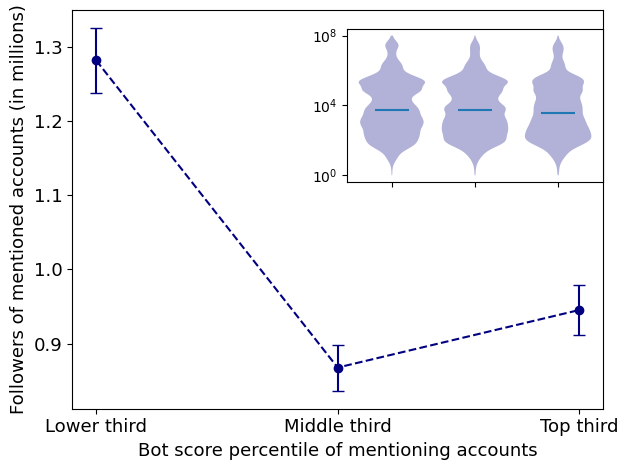

In [91]:
nbins = 3
fontsize=13
labelsize = 13

file = join(DATA_DIR, 'M8c_bot_score_followers_count.csv')
df = pd.read_csv(file, index_col=0)
gpb = df.groupby('gn')

d_mean = gpb.to_followers_count.mean()
d_std = gpb.to_followers_count.std()
d_size = gpb.size()

x = np.array(range(3))
y1 = d_mean.values / 1e6
y1err = d_std / d_size.apply(np.sqrt) / 1e6
fig, ax = plt.subplots()
ax.errorbar(x, y1, yerr=y1err, fmt='--o', capsize=4, color="navy")
ax.grid(False)

ax.set_xticks(x)
ax.xaxis.tick_bottom()
ax.set_xticklabels(['Lower third', 'Middle third', 'Top third'], fontsize=labelsize)

ax.yaxis.tick_left()
ax.tick_params(axis='y', which='major',labelsize=labelsize)

ax.set_xlabel('Bot score percentile of mentioning accounts', fontsize=fontsize)
ax.set_ylabel('Followers of mentioned accounts (in millions)', fontsize=fontsize)

# inset
iax = plt.axes([.55, .61, .4, .32])
df.loc[:, 'to_followers_count'] = np.log10(df.to_followers_count)
data = []
for name, gp in df.groupby('gn'):
    data.append(gp['to_followers_count'].values)
violins = iax.violinplot(
    data,
    vert=True,
    widths=0.8,
    showmeans=False,
    showextrema=False,
    showmedians=True,
    points=100,
)

for v in violins['bodies']:
    v.set_facecolor('navy')

iax.set_xticklabels([])
iax.xaxis.tick_bottom()

iax.set_yticks([0, 4, 8], labelsize=labelsize)
iax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, y: r'$10^%d$' % x))
iax.yaxis.tick_left()
iax.grid(False)
plt.tight_layout()
plt.show()

### Supplements

#### Figure S1

**Caption in the main paper:**
Online virality of bots and humans. Here, we compare complementary cumulative distribution functions (CCDFs) for humans vs. bots across the following dimensions: a, the number of source tweets per account; b, the number of retweets per account; c, the number of followers per account; d, the number of likes; e, the number of replies; and f, the number of retweets. The statistics in (a–c) are computed at the user level, while the statistics in (d–f) are computed at the interaction level. Statistical comparisons are based on a Kolmogorov-Smirnov (KS) test [2].

In [92]:
y_indixes = [0.001, 0.01, 0.1, 1, 10, 100]

def ccdf_plot_human_vs_bot(
        variable: str,
        xlabel: str,
        df_bot,
        df_human,
        legend=False
):
    # configurations
    tick_size = 18
    text_size = 20

    # compute KS-test
    ks = stats.kstest(df_bot[variable].values, df_human[variable].values)
    print(f"The p-value of the KS-test is: {ks.pvalue}.")
    mean_blue = df_human[variable].mean()
    mean_red = df_bot[variable].mean()
    print(f"The mean for humans is: {mean_blue} and for bots is {mean_red}.")

    # plot the ccdfs
    fig, axs = plt.subplots(figsize=(8, 8))

    # compute ccdfs
    x, y = get_ccdf(df_human, variable)
    plt.step(x, y, color="Navy", linewidth=3.0)
    x, y = get_ccdf(df_bot, variable)
    plt.step(x, y, color="firebrick", linewidth=3.0)

    # format x axis
    axs.set_xscale('log')
    axs.tick_params(axis='x', which='major', direction='out', bottom=True, size=7)
    plt.xticks(fontsize=tick_size)
    plt.xlim([1, 10000000])

    # format y axis
    plt.ylim([0.001, 101])
    axs.set_yscale("log")
    axs.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    axs.tick_params(axis='y', which='major', direction='out', left=True, size=7)
    axs.tick_params(axis='y', which='minor', direction='out', left=True, size=4)
    plt.yticks(y_indixes, fontsize=tick_size)

    # label axes
    axs.set_ylabel("CCDF (%)", fontsize=text_size)
    axs.set_xlabel(xlabel, fontsize=text_size)

    if legend:
        axs.legend(labels=["Humans", "Bots"], loc='lower right', fontsize=text_size)

    if ks.pvalue < 0.001:
        axs.text(1000, 60, "KS-test: D=" + str(np.round(ks.statistic, 3)) + ", p<" + str(0.001), fontsize=tick_size)
    else:
        axs.text(1000, 60, "KS-test: D=" + str(np.round(ks.statistic, 3)) + ", p=" + str(np.round(ks.pvalue, 3)),
                 fontsize=tick_size)
    plt.show()

##### Figure S1a

**Input data and instructions:**
`S1ab_tweet_types_per_author.csv`: number of source tweets and retweets per author and their bot scores

In [93]:
file = join(DATA_DIR, 'S1ab_tweet_types_per_author.csv')
df = pd.read_csv(file, index_col=0)

The p-value of the KS-test is: 0.4499635724567239.
The mean for humans is: 1.8389210019267823 and for bots is 2.138765768837368.


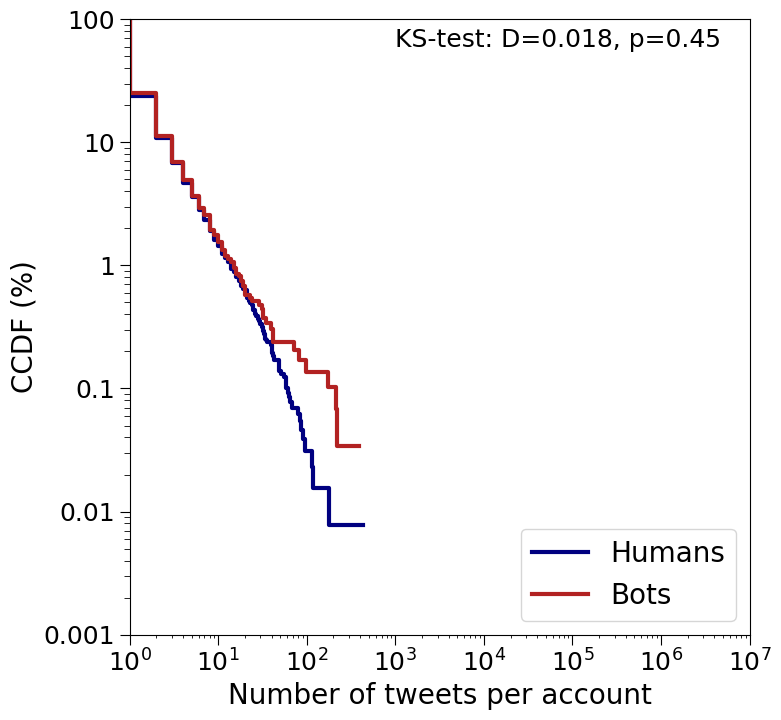

In [95]:
df_tweet = df[df["tweet_type"] == "original"]
df_tweet_bot = df_tweet[df_tweet["bot"] == 1]
df_tweet_human = df_tweet[df_tweet["bot"] == 0]

ccdf_plot_human_vs_bot(
    "count",
    "Number of tweets per account",
    df_tweet_bot,
    df_tweet_human,
    legend=True
)

##### Figure S1b

**Input data and instructions:**
`S1ab_tweet_types_per_author.csv`: number of source tweets and retweets per author and their bot scores

The p-value of the KS-test is: 1.5021513028207965e-36.
The mean for humans is: 2.1142921891524398 and for bots is 2.779291553133515.


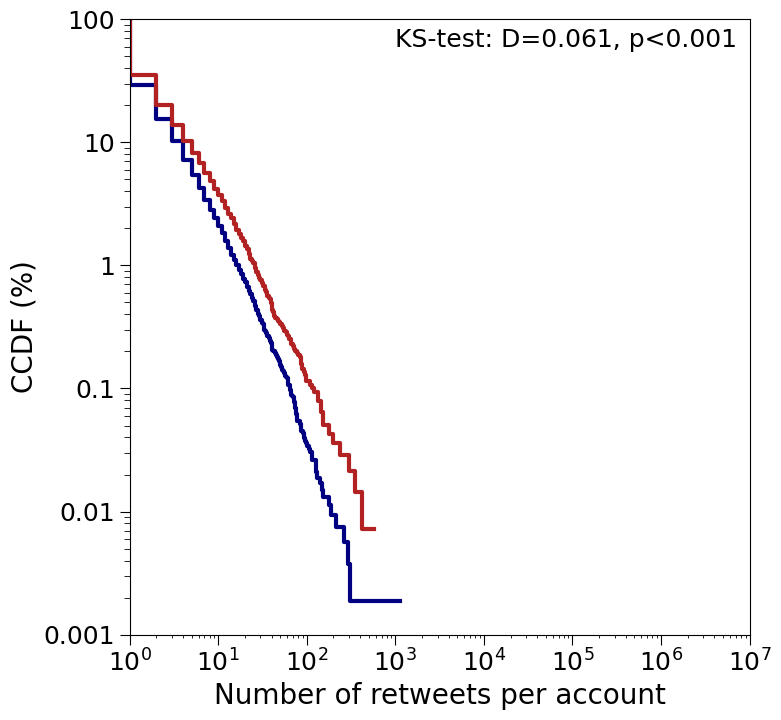

In [96]:
# plot number of tweets per account
df_tweet = df[df["tweet_type"] == "retweeted"]
df_tweet_bot = df_tweet[df_tweet["bot"] == 1]
df_tweet_human = df_tweet[df_tweet["bot"] == 0]

ccdf_plot_human_vs_bot(
    "count",
    "Number of retweets per account",
    df_tweet_bot,
    df_tweet_human
)

##### Figure S1c

**Input data and instructions:**
`S1c_author_followers_count.csv`: number of followers and bot scores of authors

The p-value of the KS-test is: 0.0.
The mean for humans is: 1772.7940716444202 and for bots is 3667.02017669532.


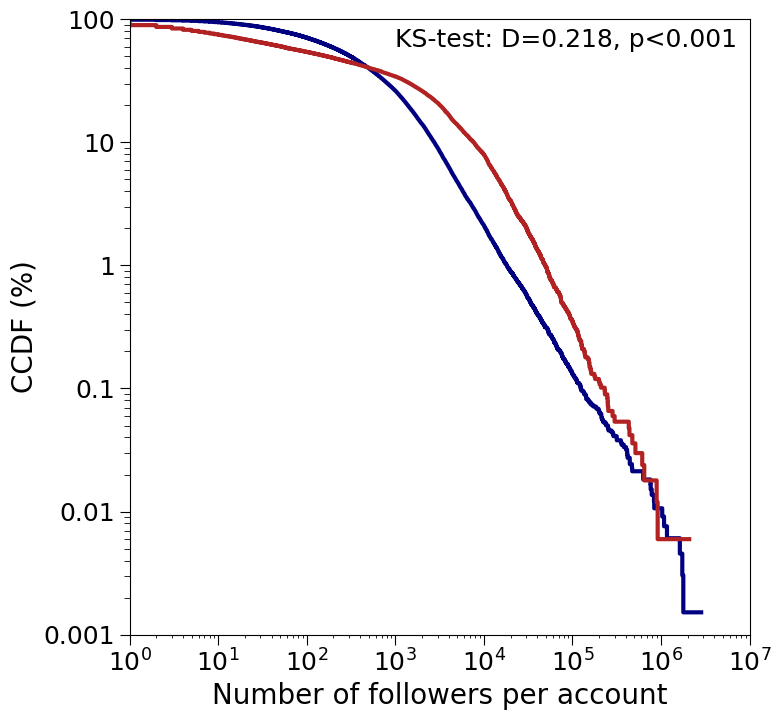

In [98]:
file = join(DATA_DIR, 'S1c_author_followers_count.csv')
df = pd.read_csv(file, index_col=0)
df_followers_human = df[df["bot"] == 0]
df_followers_bot = df[df["bot"] == 1]

ccdf_plot_human_vs_bot(
    "followers_count",
    "Number of followers per account",
    df_followers_bot,
    df_followers_human
)

##### Figure S1d-f

**Input data and instructions:**
`S1def_public_metrics.csv`: bot score as well as like, reply and retweet count of source_tweets

In [99]:
file = join(DATA_DIR, 'S1def_public_metrics.csv')
df = pd.read_csv(file, index_col=0)

df_human = df[df["bot"] == 0]
df_bot = df[df["bot"] == 1]

The p-value of the KS-test is: 6.684597954142649e-67.
The mean for humans is: 18.73214585079631 and for bots is 15.581061692969872.


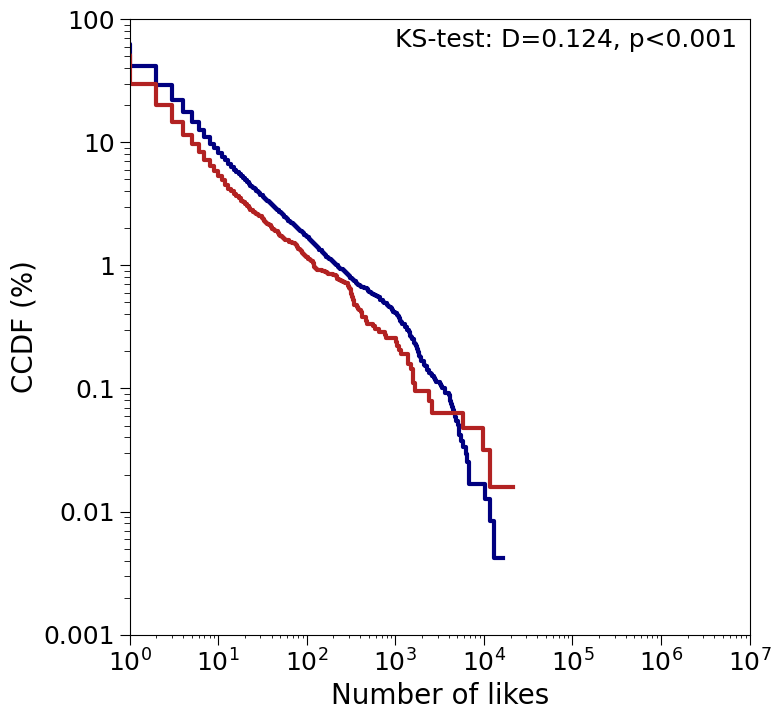

In [100]:
ccdf_plot_human_vs_bot(
    "like_count",
    "Number of likes",
    df_bot,
    df_human
)

The p-value of the KS-test is: 4.1475764743508126e-39.
The mean for humans is: 1.7036462699077954 and for bots is 1.2853499123226526.


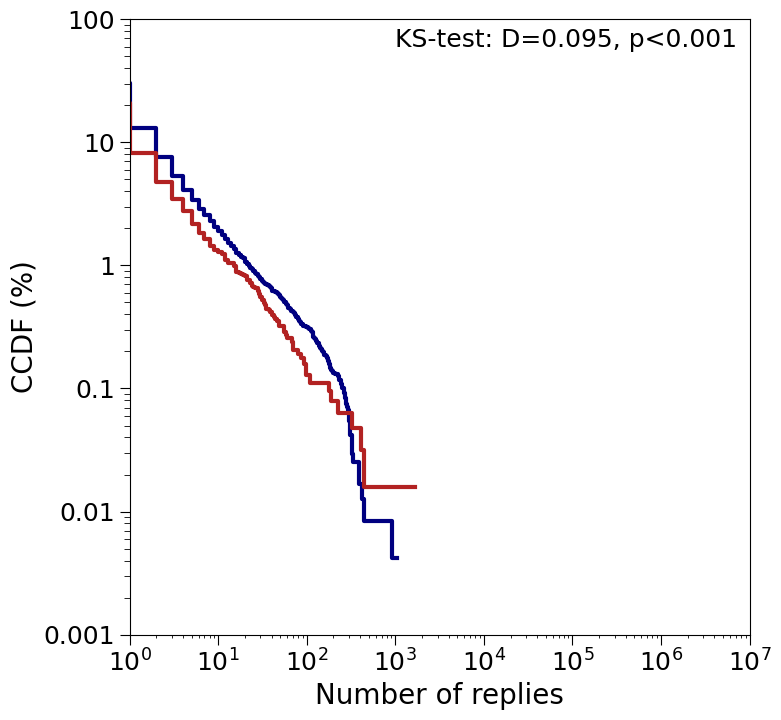

In [101]:
ccdf_plot_human_vs_bot(
    "reply_count",
    "Number of replies",
    df_bot,
    df_human
)

The p-value of the KS-test is: 2.1619758893951703e-23.
The mean for humans is: 4.719949706621962 and for bots is 4.270046229874064.


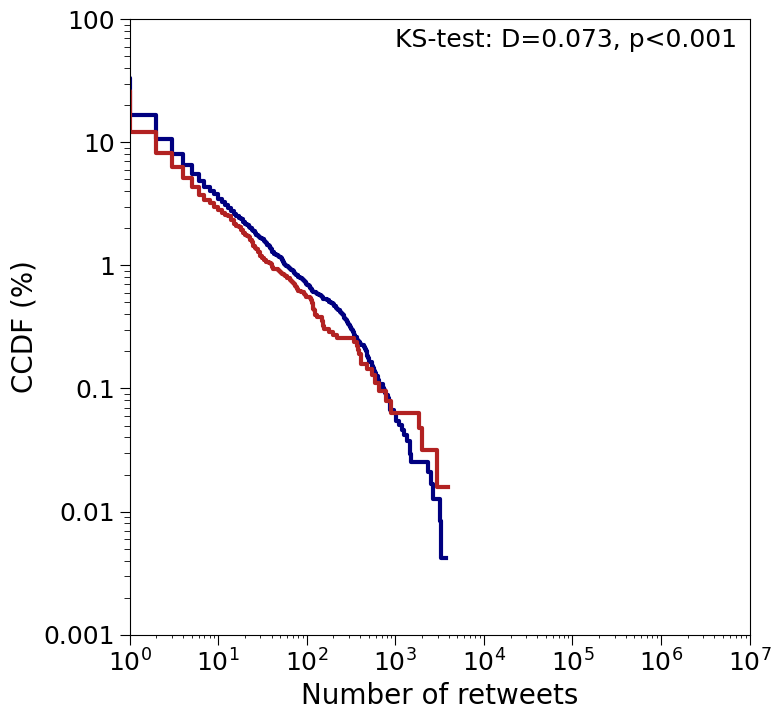

In [102]:
ccdf_plot_human_vs_bot(
    "retweet_count",
    "Number of retweets",
    df_bot,
    df_human
)

#### Figure S2

**Caption in the main paper:**
Robustness check for location analysis. Here, we perform a robustness check using a different approach where we infer the geographic location of accounts via the self-reported location in a user’s profile and via the geolocations in messages (that is, without using the heuristics based on the geographic location of followers). Shown are the differences in Russian propaganda across countries based on: a, Number of users per country (log scale). b, Relative frequency of bots per country (in %). Here, all bots were excluded where the geographic location could not be inferred. Overall, we find patterns similar to the location analysis in the main paper.

**Input data and instructions:**
`S2_locations.csv`: countries, their polygon values and the number of users and relative frequency of bots

In [103]:
file = join(DATA_DIR, 'S2_locations.csv')
df = pd.read_csv(file, index_col=0)
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry="geometry",crs=4326)

Text(1390.6530683051215, 0.5, 'Number of accounts')

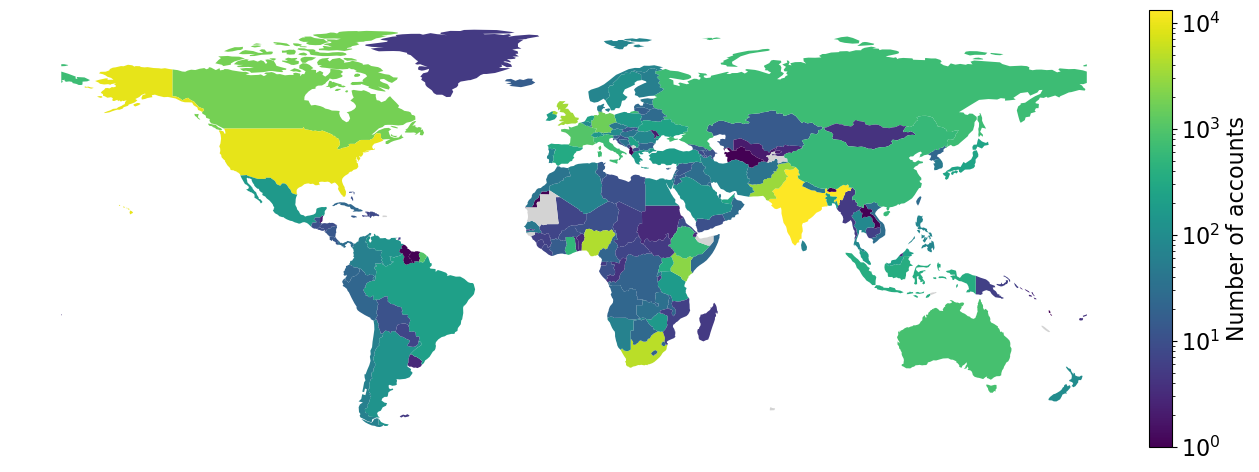

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
# create worldmap and legend space
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

# plot worldmap and legend
a = df.plot(column="users", cmap="viridis",
                     legend=True,
                     norm=colors.LogNorm(vmin=df.users.min(), vmax=df.users.max()),
                     missing_kwds= {"color": "lightgrey", "label": "Missing values"},
                     ax=ax, cax=cax)

# format worldmap
ax.axis("off")

# format legend
cax.tick_params(labelsize=16)
cax.set_ylabel('Number of accounts', rotation=90, fontsize=16)

Text(1383.0277777777776, 0.5, 'Relative frequency of bots (in %)')

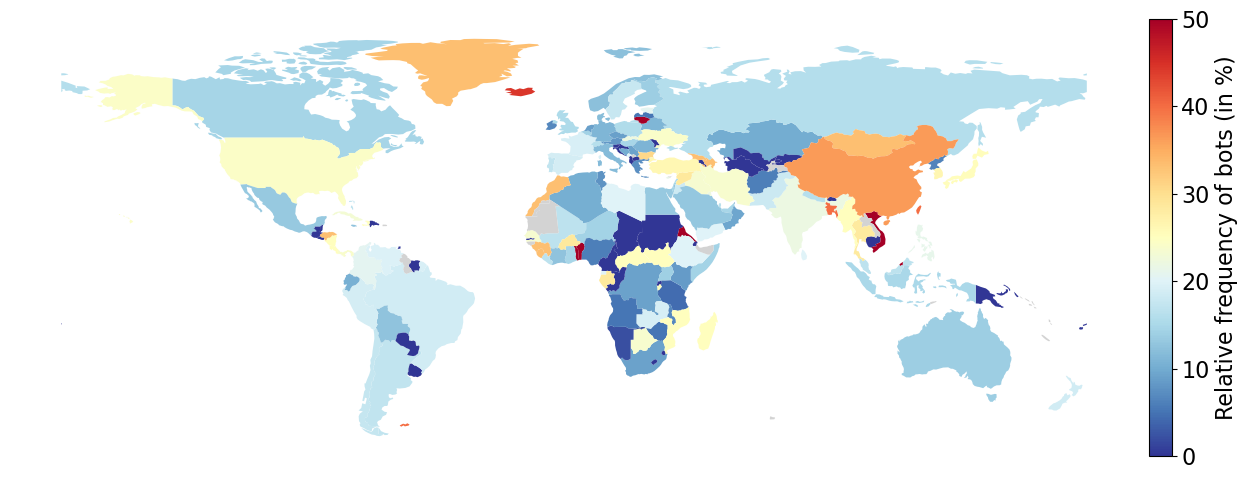

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
# create worldmap and legend space
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

# plot worldmap and legend
a = df.plot(column="bot_mean", cmap="RdYlBu_r",
                     legend=True,
                     vmax=df["bot_mean"].max(),
                     missing_kwds= {"color": "lightgrey", "label": "Missing values"},
                     ax=ax, cax=cax)

# format worldmap
ax.axis("off")

# format legend
cax.tick_params(labelsize=16)
cax.set_ylabel('Relative frequency of bots (in %)', rotation=90, fontsize=16)

#### Figure S3

**Caption in the main paper:**
Sentiment and emotions of source tweets. Here, we classified source tweets of humans and bots into different sentiment and emotion categories using the NRC lexicon [5]. Shown are: a, relative frequency of source tweets with predominantly positive, negative, or neutral sentiment for humans and bots; and b, relative frequency of the different emotions categories in source tweets from bots and humans.

**Input data and instructions:**
`S3a_sentiment.csv`: account type and the percentage of tweets with positive, negative or neutral sentiment
`S3b_emotions.csv`:


Text(0, 0.5, '')

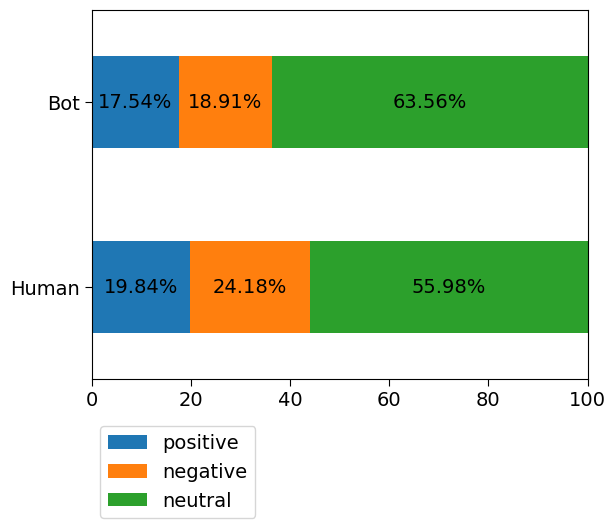

In [106]:
file = join(DATA_DIR, 'S3a_sentiment.csv')
df = pd.read_csv(file, index_col=0)


ax = df.plot.barh(stacked=True)
ax.legend(bbox_to_anchor=(0.35, -0.1), fontsize=14)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x+width/2,
            y+height/2,
            '{:.2f}%'.format(width),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=14)


plt.xlim([0,100])
ax.tick_params(axis='both', which='both', length=5,labelsize=14)

plt.ylabel('')

Text(0, 0.5, '')

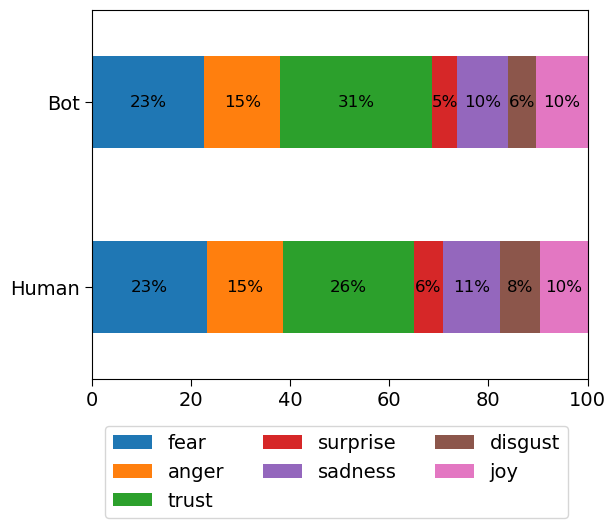

In [107]:
file = join(DATA_DIR, 'S3b_emotions.csv')
df = pd.read_csv(file, index_col=0)

ax = df.plot.barh(stacked=True)
ax.legend(bbox_to_anchor=(0.98, -0.1), ncol=3, fontsize=14)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x+width/2,
            y+height/2,
            '{:.0f}%'.format(width),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=12)


plt.xlim([0,100])
ax.tick_params(axis='both', which='both', length=5,labelsize=14)

plt.ylabel('')

#### Bibliography

[1] Varol, O., Ferrara, E., Davis, C. A., Menczer, F. & Flammini, A. Online human-bot interactions: Detection, estimation, and characterization. *Proceedings of the International AAAI Conference on Web and Social Media* **11**, 280–289 (2017).

[2] Massey, F. J. The Kolmogorov-Smirnov test for goodness of fit. *Journal of the American Statistical Association* **46**, 68–78 (1951).

[3] Bastian, M., Heymann, S. & & Jacomy, M. Gephi: An open source software for exploring and manipulating networks. In *Proceedings of the International AAAI Conference on Web and Social Media*, 3(1), 361–362 (2009).

[4] Shao, C. et al. The spread of low-credibility content by social bots. *Nature Communications* **9**, 4787 (2018).

[5] Mohammad, S. M. & Turney, P. D. Crowdsourcing a word-emotion association lexicon. *Computational Intelligence* **29**, 436–465 (2013).